In [24]:
#branch loda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from dataset_functions import *
np.random.seed(seed=10)

# Preprocessing 
Feature *chat_len*  dropped (not useful ).

Feature *match_id_hash* dropped.

Feature *lobby_type* dropped (only 0 or 7 appears which means public and ranked matchmaking, we consider both but the feature does not give us important meaning so we drop it)

Feature *game_mode* contains different values, however we are only interested in values 2 and 22, which represents the standard gamemodes for dota2 (Captain’s Mode and Ranked All Pick), so we filter the row with those value and then drop the label.

Feature game_time represents the time of the game at which we have the information needed to make the prediction. By checking the data we found a lot of *game_time=0* but with some objectives already destroyed, we decided to drop all *game_time=0* rows since it probably is an error from the APIs (Nan/not avaiable replaced with 0 maybe).

Every player has *rx_teamfight_participation*(or dx_) as a percentage of tf each player has partecipated, some where >1 and we decided to replace them with 1.

In [2]:
featureset_path = "../dataset/mlcourse-dota2-win-prediction/train_features.csv"
feature = pd.read_csv(featureset_path)
lobby_type_counts = feature['lobby_type'].value_counts()
game_mode_counts = feature['game_mode'].value_counts()

print(lobby_type_counts)
print(game_mode_counts)

lobby_type
7    27049
0    12626
Name: count, dtype: int64
game_mode
22    31762
4      3564
23     2546
3      1200
2       408
5       188
12        5
16        2
Name: count, dtype: int64


In [3]:
print(f"Data shape before preprocessing: {feature.shape}")
df, target = get_dataset()

Data shape before preprocessing: (39675, 246)
Filtering Df:  (game_mode == 2 or game_mode == 22) and game_time > 0 

Dropped:  ['lobby_type', 'chat_len', 'game_mode', 'match_id_hash'] 

Dataframe Shape:  (32153, 242) 

Target shape: (32153, 6)


# Deciding dataset
We need to handle categorical variables, the only present are the id of the hero that each player is currently playing: *r1_hero_id*.

One hot encoding is implemented to handle them but in different ways, since our initial plan was to try 3 different version of the data: 
 - *playerstats_playerheros*, considering statistic for each player (already in the dataset) and the hero he uses, this leads to the addition of 1.140 columns via one hot encoding for each hero for each player 

 - *playerstats_teamheros*, considering statistic for each player (already in the dataset) but not considering each players herom, we only consider if a hero is present in team_radiandt or in team_dire, this way one hot encoding only adds 220 columns (as final result, all the single players hero *r2_hero_id* gets dropped)

 - *teamstats_teamheros*, now we consider heros in overall team and not for each player + we sum all the statistic of the individual player into team statistics, only adding 52 features (as final result, because almost every indiviual stat gets dropped after the creation of the team statistic)

In [4]:
df_playerstats_playerheros = df.copy()
df_playerstats_teamheros = df.copy()
df_teamstats_teamheros = df.copy()

df_playerstats_playerheros = playerstats_playerheros_transform(df_playerstats_playerheros)
print(f"original data shape after pre processing{df.shape}" )
print(f"data shape playerstats_playerheros {df_playerstats_playerheros.shape}" )

original data shape after pre processing(32153, 242)
data shape playerstats_playerheros (32153, 1382)


In [5]:
df_playerstats_teamheros = playerstats_teamheros_transform(df_playerstats_teamheros)
print(f"original data shape after pre processing{df.shape}" )
print(f"data shape playerstats_teamheros {df_playerstats_teamheros.shape}" )

Hero Id Labels: ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id'] 

Numbers of Heros:  115 

Dataframe Shape: (32153, 462) 

NaN Count:  0 

original data shape after pre processing(32153, 242)
data shape playerstats_teamheros (32153, 462)


In [6]:
df_teamstats_teamheros = teamstats_teamheros_transform(df_teamstats_teamheros)
print(f"original data shape after pre processing{df.shape}")
print(f"data shape teamstats_teamheros {df_teamstats_teamheros.shape}" )

Hero Id Labels: ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id'] 

Numbers of Heros:  115 

NaN Count:  0 

Single Player Labels: ['r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold', 'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health', 'r1_max_mana', 'r1_level', 'r1_x', 'r1_y', 'r1_stuns', 'r1_creeps_stacked', 'r1_camps_stacked', 'r1_rune_pickups', 'r1_firstblood_claimed', 'r1_teamfight_participation', 'r1_towers_killed', 'r1_roshans_killed', 'r1_obs_placed', 'r1_sen_placed', 'r2_kills', 'r2_deaths', 'r2_assists', 'r2_denies', 'r2_gold', 'r2_lh', 'r2_xp', 'r2_health', 'r2_max_health', 'r2_max_mana', 'r2_level', 'r2_x', 'r2_y', 'r2_stuns', 'r2_creeps_stacked', 'r2_camps_stacked', 'r2_rune_pickups', 'r2_firstblood_claimed', 'r2_teamfight_participation', 'r2_towers_killed', 'r2_roshans_killed', 'r2_obs_placed', 'r2_sen_placed', 'r3_kills', 'r3_deaths', 'r3_assists', 'r3_denies', 'r3_gold', 'r

In [7]:
win = target["radiant_win"].astype(int)

## playerstats_playerheros

In [25]:
X_train,X_test,Y_train,Y_test = train_test_split(df_playerstats_playerheros,win,test_size=0.2)

feature_selector = RandomForestClassifier(max_depth=10,class_weight="balanced")
feature_selector.fit(X_train,Y_train)

Y_pred = feature_selector.predict(X_test)

acc = accuracy_score(Y_test,Y_pred)
auc = roc_auc_score(Y_test,Y_pred)

print("Accouracy ",acc)
print("Auc",auc)

feature_importance = {
    name: value 
    for name,value in zip(feature_selector.feature_names_in_,feature_selector.feature_importances_)
}

feature_importance = dict(reversed(sorted(feature_importance.items(), key=lambda item: item[1])))
print(feature_importance)
feature_names = list(feature_importance.keys())[:10]

print(list(feature_importance.keys()))


Accouracy  0.7048670502254704
Auc 0.7013745973319497
{'r4_y': 0.022698316413154687, 'r1_y': 0.02098560763235218, 'r3_x': 0.017995976493843425, 'd3_y': 0.017667276812240864, 'd2_y': 0.01676286940117602, 'r3_y': 0.01613869922358329, 'r5_y': 0.016007402610268874, 'd3_x': 0.015605231712162366, 'r5_x': 0.015305536898046425, 'd1_y': 0.015203884428547131, 'd4_x': 0.015179898011467617, 'r2_y': 0.014996671676644592, 'd1_x': 0.014850162691001648, 'd5_x': 0.014724543762346167, 'd2_x': 0.014380157958159535, 'r2_x': 0.014149378842480426, 'd5_y': 0.01372989471871824, 'r1_x': 0.013080822359630508, 'd4_y': 0.0121473553822036, 'r4_x': 0.011936227090523794, 'r5_deaths': 0.010517858341731145, 'r3_deaths': 0.010077507383955363, 'd2_deaths': 0.008957980782422416, 'd4_deaths': 0.008825063902670844, 'r1_deaths': 0.00835521891957863, 'd5_deaths': 0.007759822462651213, 'd5_gold': 0.007212428971137454, 'd4_gold': 0.007209825810180212, 'd3_xp': 0.007092027021569071, 'd1_xp': 0.006973170450781982, 'd2_assists': 0

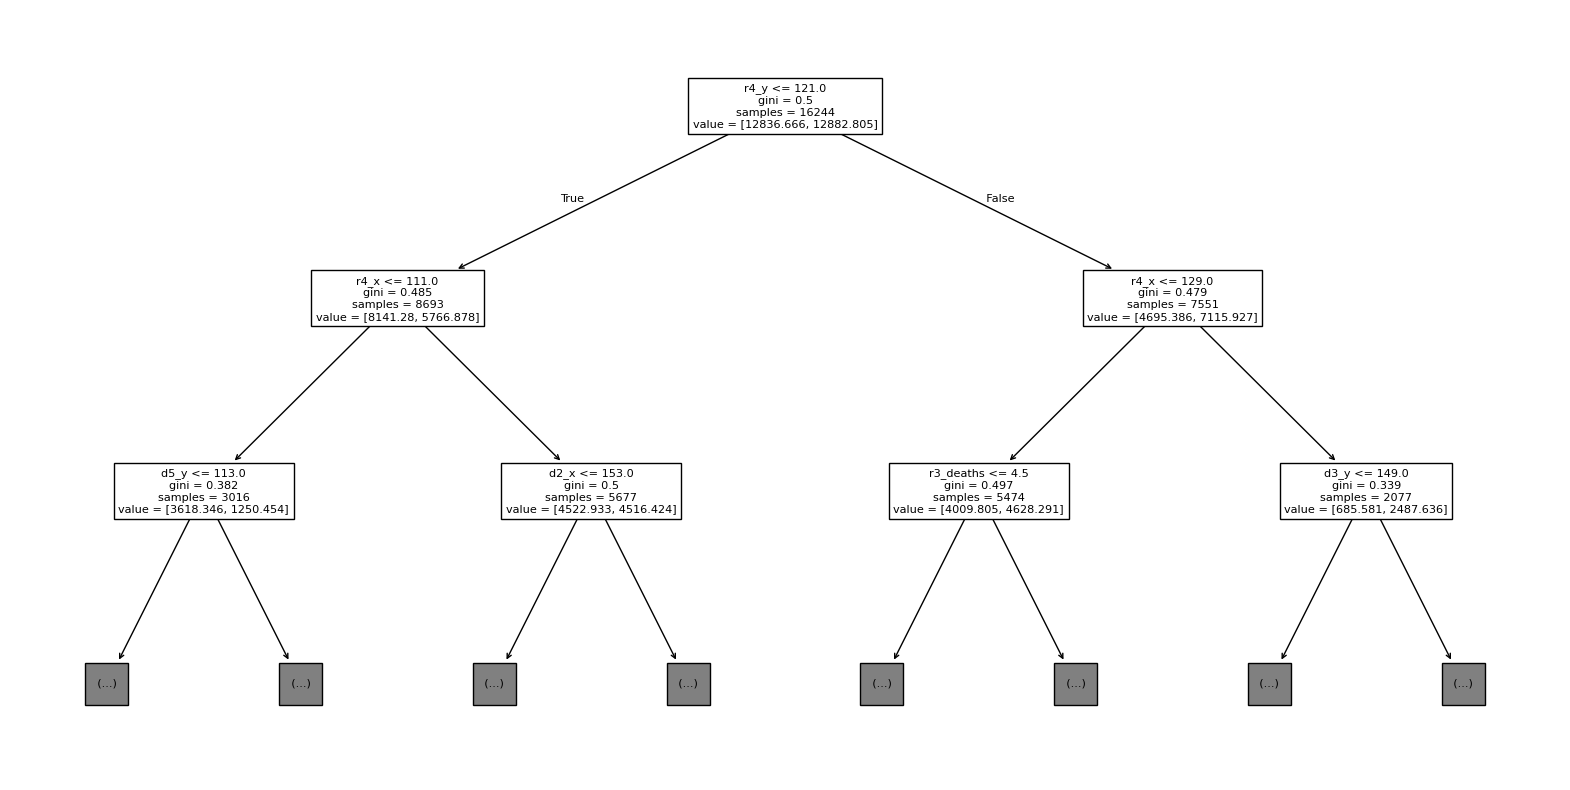

In [19]:
tree = feature_selector.estimators_[1]

plt.figure(figsize=(20,10))
plot_tree(tree,max_depth=2,feature_names=df_playerstats_playerheros.columns)
plt.show()

In [ ]:
#df = team_mean_position_transform(df)
#df = team_weighted_mean_position_transform(df)

## playerstats_teamheros

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(df_playerstats_teamheros, win, test_size=0.2)

# Initialize and train the RandomForestClassifier
feature_selector = RandomForestClassifier(max_depth=10, class_weight="balanced")
feature_selector.fit(X_train, Y_train)

# Make predictions and evaluate the model
Y_pred = feature_selector.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
auc = roc_auc_score(Y_test, Y_pred)

print("Accuracy:", acc)
print("AUC:", auc)

# Get feature importance
feature_importance = {
    name: value 
    for name, value in zip(feature_selector.feature_names_in_, feature_selector.feature_importances_)
}
feature_importance = dict(reversed(sorted(feature_importance.items(), key=lambda item: item[1])))
print(feature_importance)
feature_names = list(feature_importance.keys())[:10]

print(list(feature_importance.keys()))

Accuracy: 0.7016016171668481
AUC: 0.6973703045100443
{'r5_y': 0.02001602026716347, 'r4_y': 0.019602462800302388, 'r1_y': 0.019464497229977208, 'd1_x': 0.019119216743755475, 'r2_y': 0.018947397967391956, 'r5_x': 0.018801558018187055, 'r4_x': 0.01794248156094896, 'd5_x': 0.016542796144505174, 'r2_x': 0.016478153422889944, 'd1_y': 0.016330915963093547, 'd3_y': 0.016049743592340307, 'd4_x': 0.015806463102348543, 'r3_y': 0.014834545902097878, 'd2_y': 0.014792816682988884, 'r3_x': 0.014091053094011903, 'd3_x': 0.014072498577696315, 'd2_x': 0.013629689661512387, 'd5_y': 0.013320698974341716, 'd4_y': 0.01330602858982864, 'r1_x': 0.012558510647981606, 'r4_deaths': 0.010292569939609092, 'r1_deaths': 0.00922124577183948, 'd3_deaths': 0.008966328677409265, 'd2_gold': 0.008677896029605883, 'd4_deaths': 0.008481653326417144, 'r2_deaths': 0.008236666147852605, 'r3_deaths': 0.0077177686151052895, 'd1_gold': 0.0076077711613903596, 'd2_deaths': 0.007282642785402106, 'd5_deaths': 0.007178969837903935, 'd

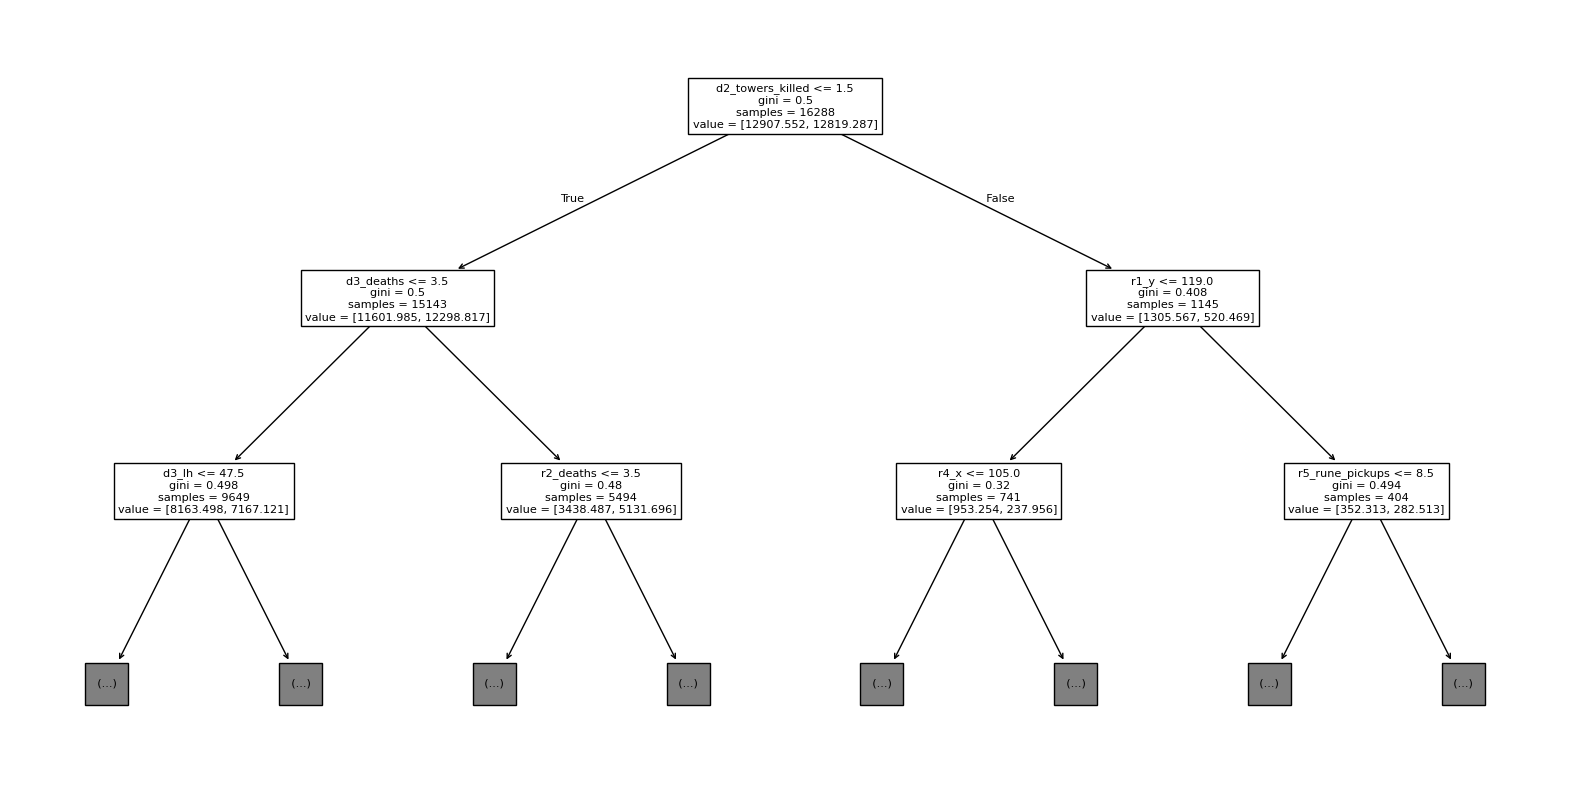

In [27]:
# Plot one of the trees in the forest
tree = feature_selector.estimators_[1]
plt.figure(figsize=(20, 10))
plot_tree(tree, max_depth=2, feature_names=df_playerstats_teamheros.columns)
plt.show()

## teamstats_teamheros

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(df_teamstats_teamheros, win, test_size=0.2)

# Initialize and train the RandomForestClassifier
feature_selector = RandomForestClassifier(max_depth=10, class_weight="balanced")
feature_selector.fit(X_train, Y_train)

# Make predictions and evaluate the model
Y_pred = feature_selector.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
auc = roc_auc_score(Y_test, Y_pred)

print("Accuracy:", acc)
print("AUC:", auc)

# Get feature importance
feature_importance = {
    name: value 
    for name, value in zip(feature_selector.feature_names_in_, feature_selector.feature_importances_)
}
feature_importance = dict(reversed(sorted(feature_importance.items(), key=lambda item: item[1])))
print(feature_importance)
feature_names = list(feature_importance.keys())[:10]

print(list(feature_importance.keys()))

Accuracy: 0.715440833462914
AUC: 0.7120661743329132
{'d_kills': 0.033566103119684325, 'r_towers_killed': 0.03277588165190524, 'd_towers_killed': 0.029854998165914762, 'r_deaths': 0.02970639283395864, 'd_deaths': 0.026570244654638177, 'r_kills': 0.02656442493818528, 'r1_y': 0.024407516924454323, 'r2_y': 0.023234294150748264, 'd_rune_pickups': 0.021495906066022075, 'r5_x': 0.021251200926845164, 'd_gold': 0.019789733458609782, 'r5_y': 0.01977140286399406, 'r_gold': 0.019193619461614828, 'r_rune_pickups': 0.019012197599683093, 'd2_y': 0.018771758734910788, 'd5_y': 0.018499574438249664, 'd_xp': 0.018277746262203565, 'd3_x': 0.018108086695952774, 'd_assists': 0.017467629378604223, 'r1_x': 0.0170497177709186, 'r4_x': 0.016994735615766046, 'd3_y': 0.016726632477115803, 'r4_y': 0.016691122628215097, 'r2_x': 0.016576997262636582, 'd1_x': 0.016380116157042282, 'r3_y': 0.016269251335251686, 'd4_y': 0.01588644330967118, 'r_denies': 0.01582538970901734, 'r_max_health': 0.015657994798125973, 'd_max_h

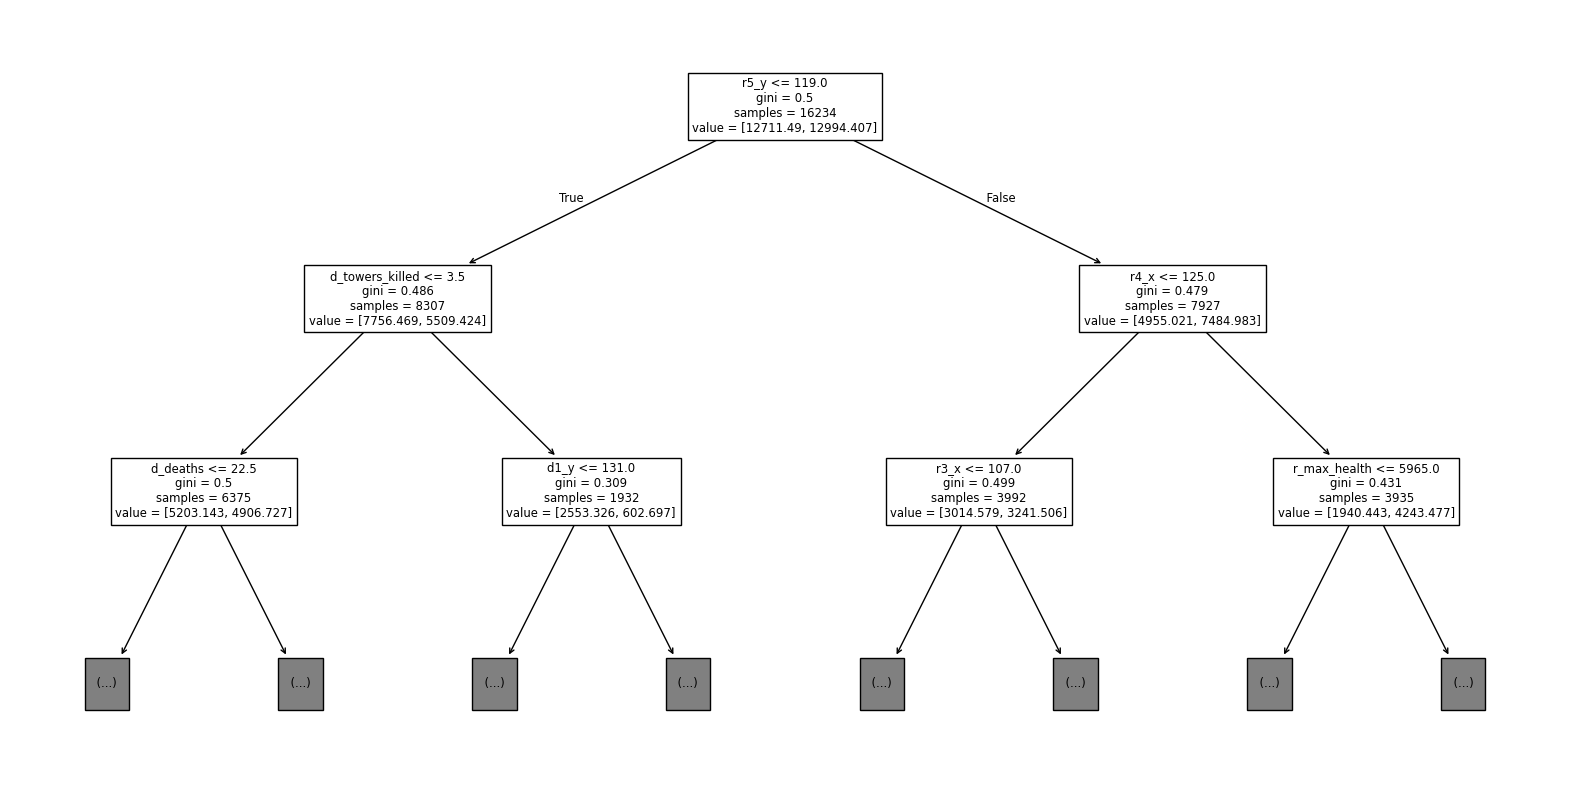

In [23]:
tree = feature_selector.estimators_[1]
plt.figure(figsize=(20, 10))
plot_tree(tree, max_depth=2, feature_names=df_teamstats_teamheros.columns)
plt.show()